<h2><center><font color="black"><strong>Model for flats in Marseille</strong></font></center></h2>

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [48]:
    # Models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

    # Pipeline & Preprocess
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

    # Scores
from sklearn.metrics import balanced_accuracy_score, make_scorer, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error , r2_score
from sklearn.metrics import mean_absolute_percentage_error

In [64]:
df_maison = pd.read_csv('../Data/df_Marseille_Maison_sansProcess_2.csv', low_memory = False, encoding = 'latin1')

In [20]:
%run '../Helpers/Data_Process.py'

In [21]:
%run '../Helpers/Models.py'

In [22]:
%run '../Helpers/Data_visualisation.py'

In [68]:
df_train = df_maison[df_maison['date_mutation'] < '2021-04-01']
df_test = df_maison[df_maison['date_mutation'] >= '2021-04-01']

In [69]:
df_test.shape[0] / (df_train.shape[0] + df_test.shape[0])

0.13314779551779699

In [70]:
df_train = pd.concat([df_train, pd.get_dummies(df_train[['quarter']])], axis = 1)

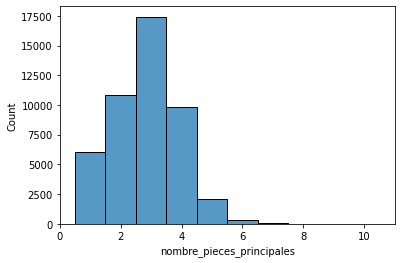

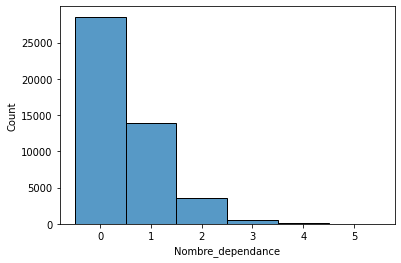

In [53]:
import seaborn as sc
sc.histplot(df['nombre_pieces_principales'], discrete = True)
plt.show()
sc.histplot(df[df.Nombre_dependance < 6]['Nombre_dependance'], discrete = True)
plt.show()

13201


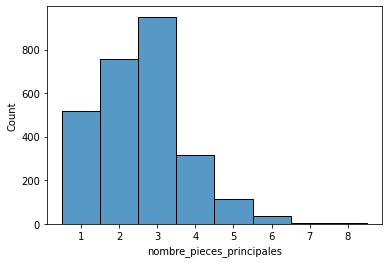

13202


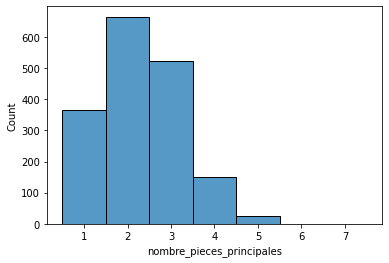

13203


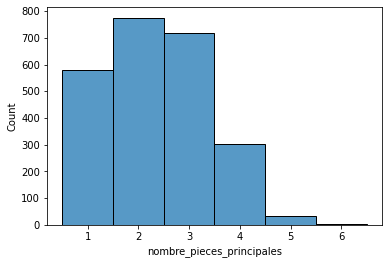

13204


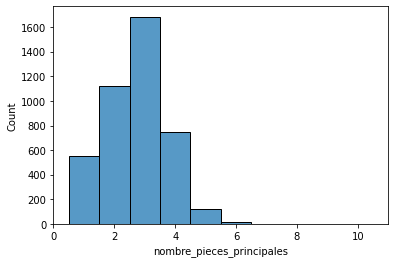

13205


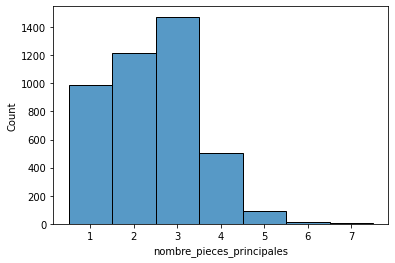

13206


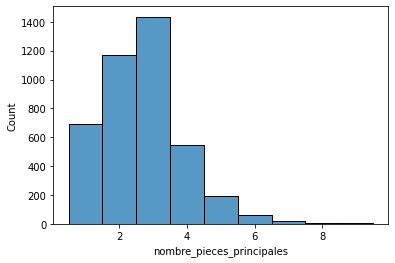

13207


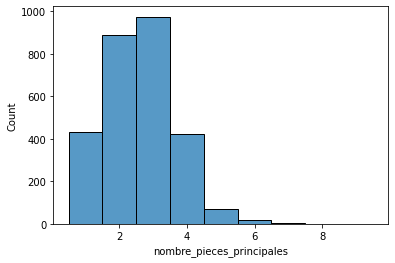

13208


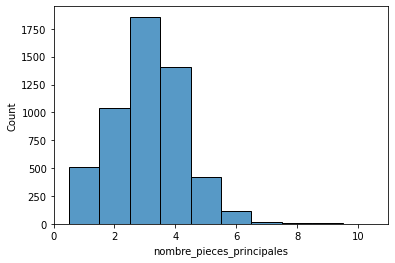

13209


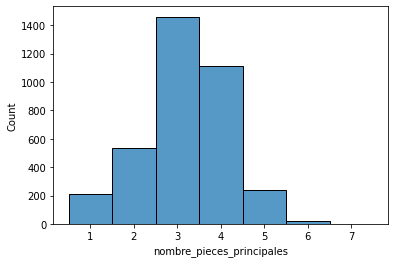

13210


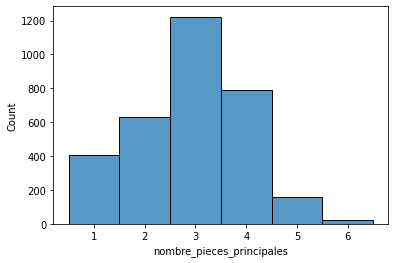

13211


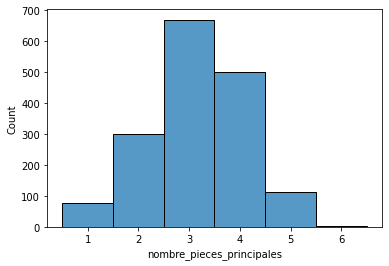

13212


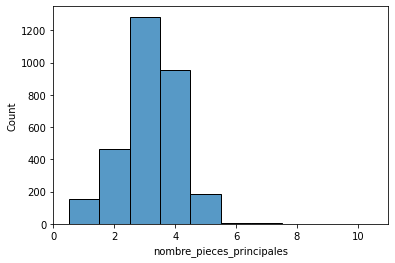

13213


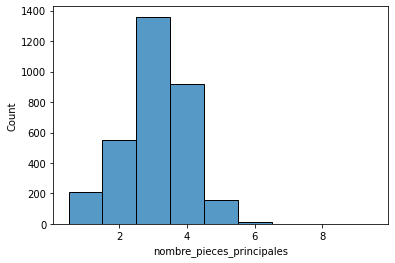

13214


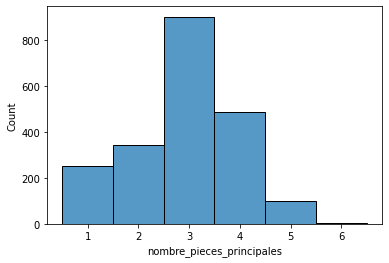

13215


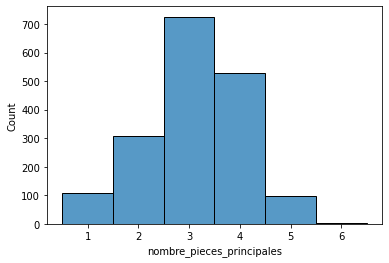

In [54]:
for i in range(1,16) : 
    code = 13200+i
    print(code)
    df_arr = df[df['code_commune'] == code]
    sc.histplot(df_arr['nombre_pieces_principales'], binwidth=1, discrete = True)
    plt.show()

13201


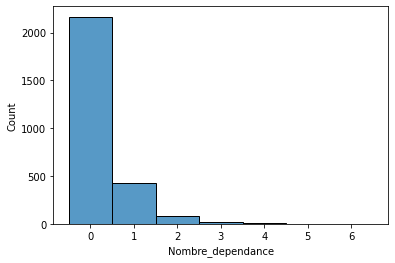

13202


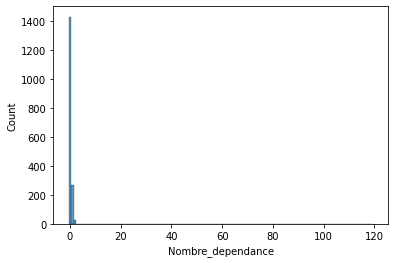

13203


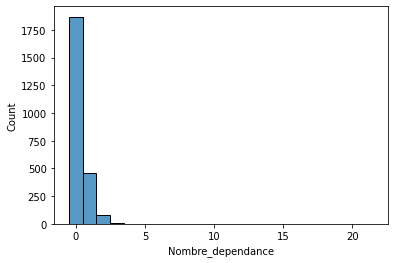

13204


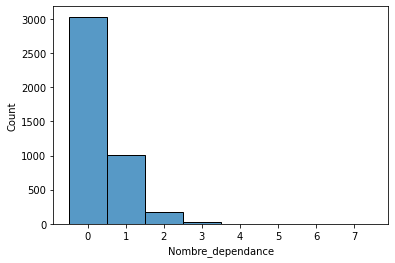

13205


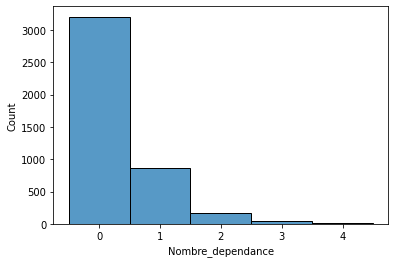

13206


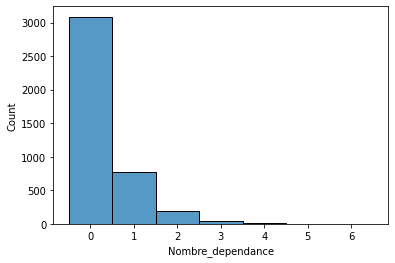

13207


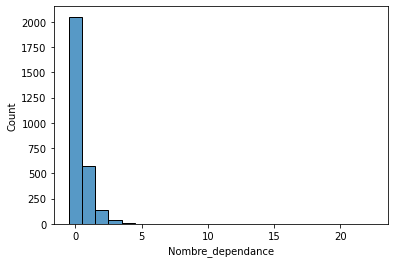

13208


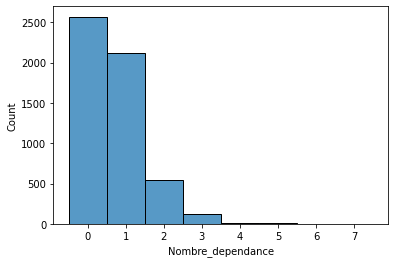

13209


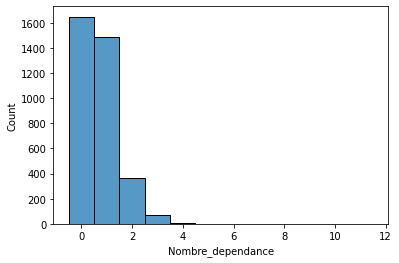

13210


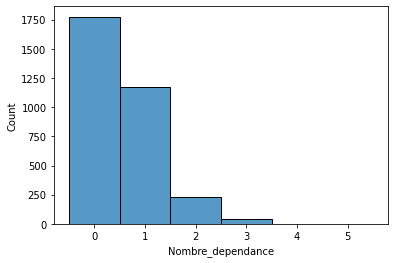

13211


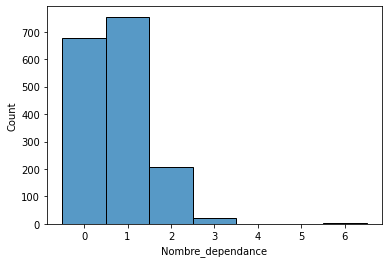

13212


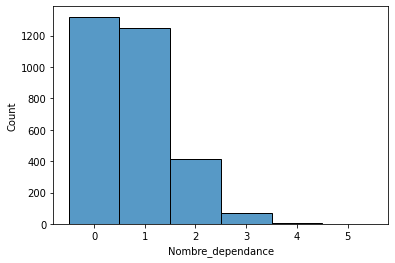

13213


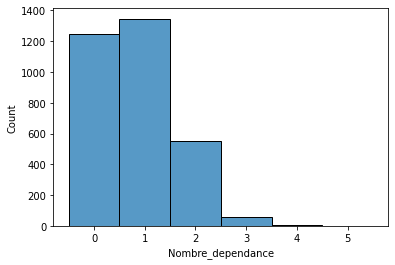

13214


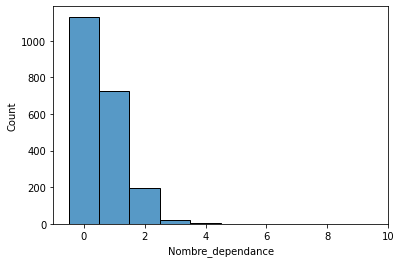

13215


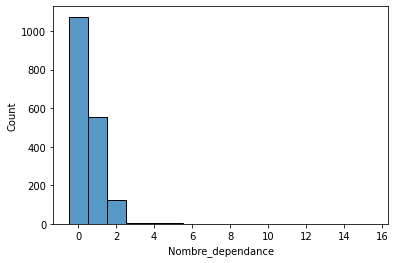

In [55]:
for i in range(1,16) : 
    code = 13200+i
    print(code)
    df_arr = df[df['code_commune'] == code]
    sc.histplot(df_arr['Nombre_dependance'], binwidth=1, discrete = True)
    plt.show()

In [71]:
df_train['n_pieces_BienStandard'] = df_train['nombre_pieces_principales']-3
df_train['n_dependances_BienStandard'] = df_train['Nombre_dependance']

In [72]:
features_ols = ['quarter_2017_Q4', 'quarter_2018_Q1', 'quarter_2018_Q2', 'quarter_2018_Q3',
'quarter_2018_Q4', 'quarter_2019_Q1', 'quarter_2019_Q2',
'quarter_2019_Q3', 'quarter_2019_Q4', 'quarter_2020_Q1',
'quarter_2020_Q2', 'quarter_2020_Q3', 'quarter_2020_Q4',
'quarter_2021_Q1',
'n_pieces_BienStandard', 'n_dependances_BienStandard']
outcome = 'Prix_m2'

In [74]:
model = model_OLS_prix(df_train, 'Prix_m2', features_ols, summary = True)

                            OLS Regression Results                            
Dep. Variable:                Prix_m2   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     22.30
Date:                Sun, 02 Apr 2023   Prob (F-statistic):           4.61e-64
Time:                        21:50:07   Log-Likelihood:                -58902.
No. Observations:                5918   AIC:                         1.178e+05
Df Residuals:                    5901   BIC:                         1.180e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

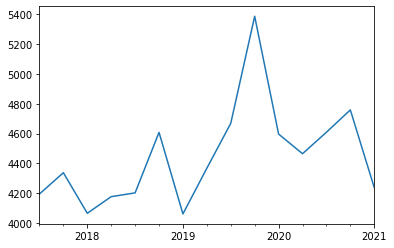

In [75]:
df_train = add_indice_prix(df_train, indice_prix_quarter(model, plot = True))

In [83]:
df_test_vif = df_maison[['Nombre_dependance',
                  'N_apparts', 'Part_chomeurs', 'Ec_maternelle', 'Ec_elementaire',
                  'dist_metro', 'DISP_MED19']]

In [84]:
calc_vif(df_test_vif)

,variables,VIF
0,Nombre_dependance,1.034095
1,N_apparts,4.710765
2,Part_chomeurs,6.365727
3,Ec_maternelle,3.088903
4,Ec_elementaire,3.124957
5,dist_metro,2.010377
6,DISP_MED19,5.317292


# KNN

In [86]:
    # Dependant variables : cooridnates
features_knn = ['latitude', 'longitude']
    # Output
label_train = 'Prix_m2_actualise_Q1_2021'
label_test = 'Prix_m2'

In [89]:
knn_pipe = model_KNN_coordinates(df_train, df_test, features_knn,
                          label_train, label_test,
                          MinMaxScaler(), 'uniform', 25, 5)

Returned hyperparameter: {'Knn__n_neighbors': 23}


In [90]:
compute_scores(knn_pipe, df_train[features_knn], df_train[label_train])

MAPE:  43.22557472034513
MDAPE:  19.577871288489522


In [91]:
    # Scores on TEST dataset
compute_scores(knn_pipe, df_test[features_knn], df_test[label_test])

MAPE:  30.665427040080782
MDAPE:  21.259239683150103


# Rf

In [92]:
features_RF = ['nombre_pieces_principales','Nombre_dependance',
                  'N_apparts', 'Part_chomeurs', 'Ec_maternelle', 'Ec_elementaire',
                  'dist_metro', 'DISP_MED19']

In [96]:
RF_model = model_RF_post_KNN(df_test, df_train, features_RF, features_knn, label_train, label_test,
                      model_knn = knn_pipe, standardisation = StandardScaler(), range_depth = [10, 20, 30, 50, 70], nb_cv = 5)

In [97]:
X_train_rf = df_train[features_RF]
X_train_rf['y_pred_knn'] = knn_pipe.predict(df_train[features_knn])
X_test_rf = df_test[features_RF]
X_test_rf['y_pred_knn'] = knn_pipe.predict(df_test[features_knn])
compute_scores(RF_model, X_test_rf, df_test[label_test])

MAPE:  31.288222816652922
MDAPE:  20.91495875440063


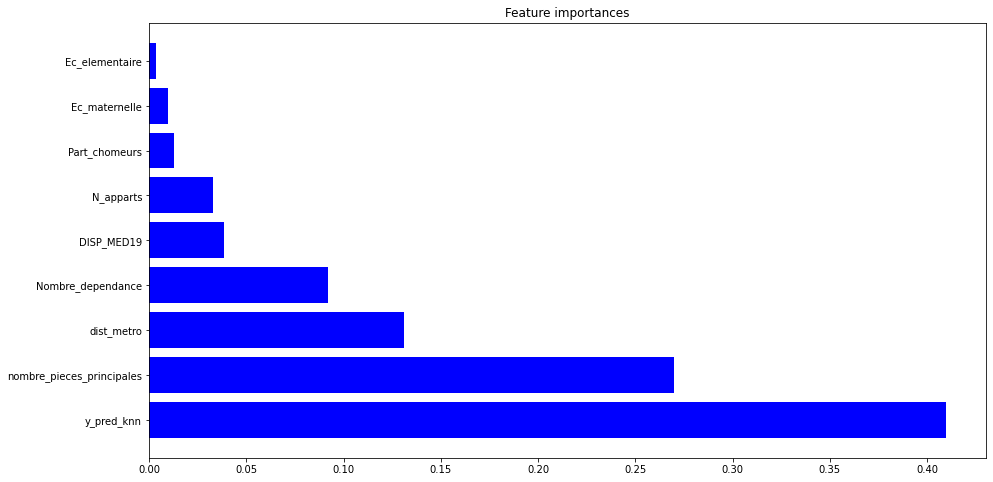

In [98]:
RF_importances = RF_model.best_estimator_.named_steps["RForest"].feature_importances_
features_importances(RF_importances, X_train_rf)